In [ ]:
import glob
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def create_model(base_model, classData):
    for layer in base_model.layers:
        layer.trainable = False
    top_model = base_model.output 
    #flatten layer
    top_model = Flatten(name="flatten")(top_model)
    #dense layer
    top_model = Dense(1024, activation='relu')(top_model)
    #dropout layer
    top_model = Dropout(0.2)(top_model)
    #dense layer
    output_layer = Dense(classData, activation='softmax')(top_model)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])        
            
    return model


train_path = '/content/drive/MyDrive/PaddyDisease/balanced_oversampling'
test_path  = '/content/drive/MyDrive/PaddyDisease/test_data'
IMG_SHAPE = (256, 256, 3)
batch_size = 32
classData = 10

base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model = create_model(base_model, classData)
# model.summary()

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(256,256),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=batch_size
)

Found 10000 files belonging to 10 classes.
Using 9000 files for training.
Found 10000 files belonging to 10 classes.
Using 1000 files for validation.


In [ ]:
#custom callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
282/282 [==============================] - 217s 657ms/step - loss: 1.1001 - accuracy: 0.6733 - val_loss: 0.5704 - val_accuracy: 0.8290
Epoch 2/10
282/282 [==============================] - 8s 26ms/step - loss: 0.2992 - accuracy: 0.9059 - val_loss: 0.3963 - val_accuracy: 0.8900
Epoch 3/10
282/282 [==============================] - 8s 27ms/step - loss: 0.1614 - accuracy: 0.9504 - val_loss: 0.4394 - val_accuracy: 0.8760
Epoch 4/10
282/282 [==============================] - 8s 26ms/step - loss: 0.1099 - accuracy: 0.9676 - val_loss: 0.3813 - val_accuracy: 0.9000
Epoch 5/10
282/282 [==============================] - 8s 27ms/step - loss: 0.1020 - accuracy: 0.9707 - val_loss: 0.7084 - val_accuracy: 0.8290
Epoch 6/10
282/282 [==============================] - 8s 26ms/step - loss: 0.0917 - accuracy: 0.9724 - val_loss: 0.4151 - val_accuracy: 0.8980
Epoch 7/10
282/282 [==============================] - 8s 26ms/step - loss: 0.0744 - accuracy: 0.9797 - val_loss: 0.4147 - val_accuracy: 0.8

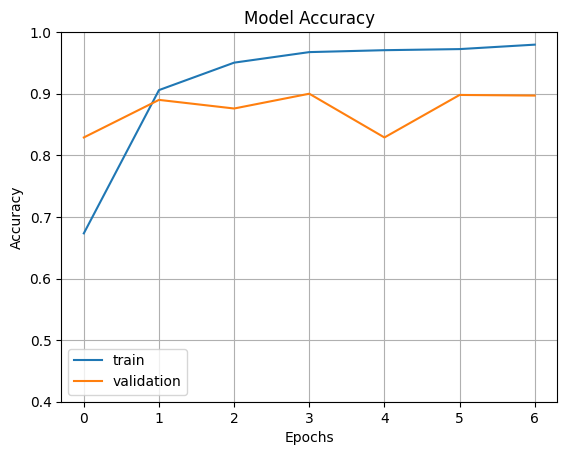

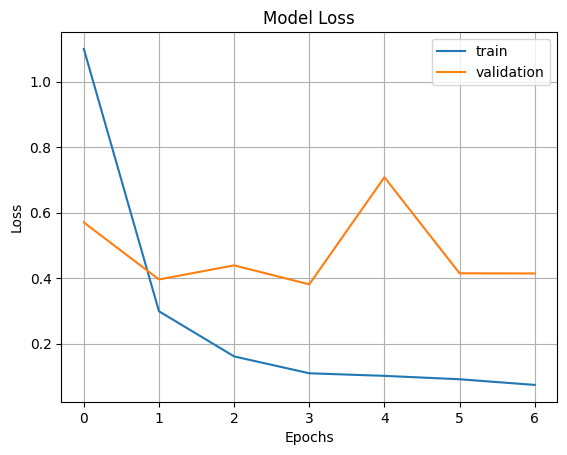

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
# axes[0].plot(x1, y1)
# axes[1].plot(x2, y2)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=1
)

predictions = model.predict(test_ds)

Found 1000 files belonging to 10 classes.
1000/1000 [==============================] - 20s 18ms/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names, digits=4))

                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.8812    0.8900    0.8856       100
   bacterial_leaf_streak     1.0000    0.8900    0.9418       100
bacterial_panicle_blight     0.9485    0.9200    0.9340       100
                   blast     0.9158    0.8700    0.8923       100
              brown_spot     0.9655    0.8400    0.8984       100
              dead_heart     0.9406    0.9500    0.9453       100
            downy_mildew     0.8900    0.8900    0.8900       100
                   hispa     0.9208    0.9300    0.9254       100
                  normal     0.8762    0.9200    0.8976       100
                  tungro     0.7661    0.9500    0.8482       100

                accuracy                         0.9050      1000
               macro avg     0.9105    0.9050    0.9059      1000
            weighted avg     0.9105    0.9050    0.9059      1000



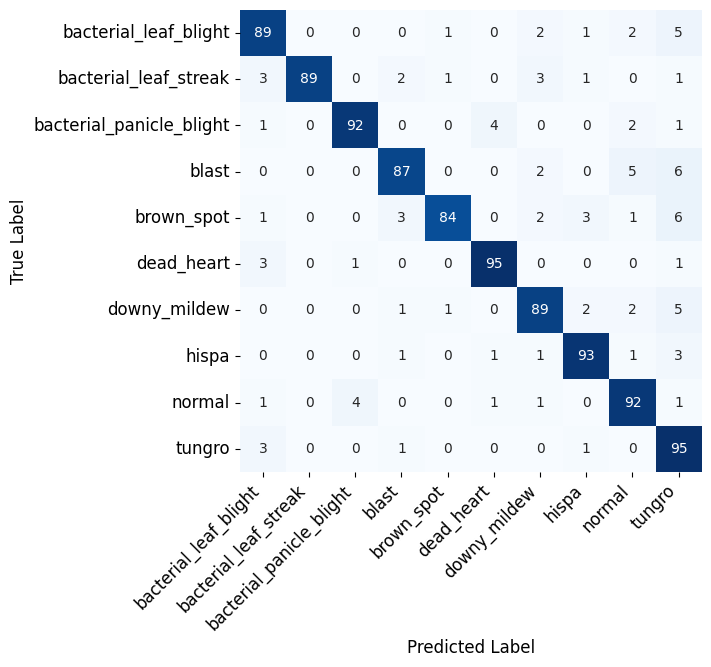

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="EfficientNetV2B0-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EfficientNetV2B0_OverSampling_256_v2.h5')